# WEEK 4:

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import requests
import geocoder # import geocoder
from geopy.geocoders import Nominatim 
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CLIENT_ID = 'NNO2TDZ2XO2YHCMISLHPTUFBAK0YDZBX3RTF04YY4Q5FVR1W' # your Foursquare ID
CLIENT_SECRET = 'UTNENPNX0IFTQP1VPKXI035AFXQEC5XJCN0XJ5YRMYB05HAH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500, LIMIT=20000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [4]:
def clusterCorrelations(corr_matrix, cluster_number, sortby_corr_strength=False):
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(corr_matrix)
    corr_matrix['cluster_labels']=kmeans.labels_
        
    cluster_labels_df=corr_matrix['cluster_labels'].value_counts().to_frame()
    cluster_labels_df=cluster_labels_df.rename(columns={'cluster_labels': 'cluster_size'})
    
    for i in range(0, cluster_number):
        cluster_types=corr_matrix[corr_matrix.cluster_labels==i].index.values.tolist()
        cluster_labels_df.loc[i, 'corr_strength']= np.abs(corr_matrix.loc[cluster_types, cluster_types].mean().mean())
        
    cluster_labels_df['new label']=1
    if sortby_corr_strength:
        cluster_labels_df['new label']=cluster_labels_df.sort_values('corr_strength', ascending=False)['new label'].cumsum()
        cluster_size_list=cluster_labels_df.sort_values('corr_strength', ascending=False).cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']].sort_values('corr_strength', ascending=False))

    else:
        cluster_labels_df['new label']=cluster_labels_df['new label'].cumsum()
        luster_size_list=cluster_labels_df.cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']])
    
    corr_matrix['cluster_labels']=corr_matrix['cluster_labels'].apply(lambda x: cluster_labels_df.loc[x]['new label'])    
    clustered_venues=corr_matrix.sort_values('cluster_labels').index.values.tolist()
    corr_matrix=corr_matrix.loc[clustered_venues, clustered_venues+ ['cluster_labels']]    
        
    for i in range(cluster_number):
        print('\n Cluster {}:'.format(i+1), corr_matrix[corr_matrix.cluster_labels==i+1].index.values.tolist())
        
    fig, (ax1, ax2)=plt.subplots(1,2)
    ax1.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')
    ax2.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')    
    
    cluster_line=0
    for cluster_size in cluster_size_list:
        cluster_line+=cluster_size
        ax2.axhline(cluster_line-0.5)
        ax2.axvline(cluster_line-0.5)
    
    plt.show()

### Scrape the Table on the given Wikipedia Page with Beautiful Soup and Display the head of the DataFrame

In [5]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)

In [6]:
soup = BeautifulSoup(page.text, "html.parser")
table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
df=pd.DataFrame(l, columns=["Postcode", "Borough", "Neighbourhood"])
df=df[df['Borough']!='Not assigned'].dropna()
df['Neighbourhood']=df['Neighbourhood'].str.replace('\n','')

In [133]:
df

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [7]:
# Group together rows with the same postalcode as required
df=df.groupby(['Postcode', 'Borough']).agg(lambda col: ', '.join(col)).reset_index()

# Fill 'Not- assigned'-values in Neighbourhood-Column with Borough-Name and display the changed rows
na_idx=df[df.Neighbourhood.str.contains('Not assigned')].index
df.loc[na_idx,'Neighbourhood']=df.loc[na_idx,'Borough']

### Filter on Toronto Boroughs only
toronto_df=df[df.Borough.str.contains('Toronto')]

# Load coordinates and merge
coordinates=pd.read_csv('Geospatial_Coordinates.csv')
toronto_df=pd.merge(toronto_df, coordinates, left_on='Postcode', right_on='Postal Code').drop('Postal Code', axis=1)

In [134]:
toronto_df

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


### Get Venues Nearby

In [8]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

### One hot-encoding for the venues

In [147]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = toronto_onehot.columns.tolist()
fixed_columns.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + fixed_columns
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot

,Neighborhood,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Caribbean Restaurant,Castle,Cemetery,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nudist Beach,Optical Shop,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pide Place,Pizza Place,Playground,Plaza,Pool,Pool Hall,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Cluster Venues bases on Corrleation of their occurences

## Filter on Top Venues only in order to avoid getting high correlations due to single/low-number data points

In [10]:
pd.options.display.max_rows=20
pd.options.display.max_columns=1000

In [150]:
venue_count=toronto_onehot.drop('Neighborhood', axis=1).T.sum(axis=1).to_frame()
venue_count=venue_count.rename(columns={0:'count'})
venue_count=venue_count.sort_values('count', ascending=False)
top_venue_types=venue_count.iloc[0:int(venue_count.shape[0]/4)].index.values.tolist()
venue_count

,count
Coffee Shop,257
Café,236
Park,155
Italian Restaurant,153
Bakery,93
Pizza Place,86
Hotel,79
Japanese Restaurant,77
Restaurant,75
Bar,68


In [12]:
toronto_onehot=toronto_onehot[['Neighborhood']+top_venue_types]

# Get Correlation for different vanues based on the data of different neighborhoods

In [13]:
venue_corr=toronto_onehot.groupby(['Neighborhood']).sum().corr()

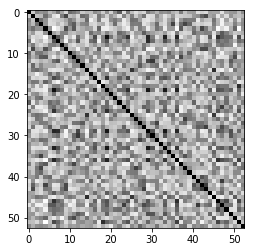

In [14]:
plt.imshow(venue_corr,cmap='Greys',interpolation='nearest')

In [132]:
np.array(venue_corr)

array([[ 1.        , -0.22567676,  0.20547143, ..., -0.11086554,
         0.17328855,  7.        ],
       [-0.22567676,  1.        , -0.17096877, ..., -0.13604798,
        -0.04634679,  3.        ],
       [ 0.20547143, -0.17096877,  1.        , ..., -0.31866718,
         0.14222041,  8.        ],
       ...,
       [ 0.1084818 , -0.08151535,  0.13795157, ..., -0.32489216,
         0.05481266,  7.        ],
       [-0.11086554, -0.13604798, -0.31866718, ...,  1.        ,
        -0.13839518,  2.        ],
       [ 0.17328855, -0.04634679,  0.14222041, ..., -0.13839518,
         1.        ,  1.        ]])

In [15]:
scores=list()

for kclusters in range(1,venue_corr.shape[0]):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_corr)
    scores.append(kmeans.score(venue_corr))

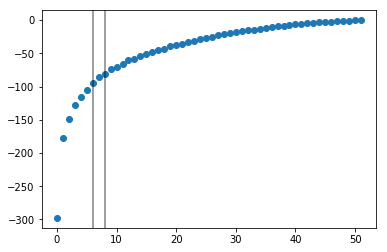

In [16]:
plt.axvline(6, color='k', alpha=0.5)
plt.axvline(8, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

Number of clusters 4


,new label,corr_strength,cluster_size
2,1,0.544276,12
3,2,0.371863,9
1,3,0.235847,18
0,4,0.228912,14



 Cluster 1: ['Steakhouse', 'Theater', 'Concert Hall', 'Thai Restaurant', 'Farmers Market', 'Plaza', 'Museum', 'Diner', 'Hotel', 'Mediterranean Restaurant', 'Comic Shop', 'Japanese Restaurant']

 Cluster 2: ['Bar', 'Asian Restaurant', 'Vietnamese Restaurant', 'Mexican Restaurant', 'Bakery', 'Brewery', 'Yoga Studio', 'Café', 'Cocktail Bar']

 Cluster 3: ['Pub', 'Coffee Shop', 'Grocery Store', 'Tea Room', 'Liquor Store', 'BBQ Joint', 'Burger Joint', 'Breakfast Spot', 'Spa', 'French Restaurant', 'Ramen Restaurant', 'Indian Restaurant', 'Park', 'Middle Eastern Restaurant', 'Italian Restaurant', 'Ice Cream Shop', 'Sushi Restaurant', 'Gastropub']

 Cluster 4: ['Movie Theater', 'Art Gallery', 'Pizza Place', 'Restaurant', 'Seafood Restaurant', 'Sandwich Place', 'Gym', 'Dessert Shop', 'Bookstore', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Beer Bar', 'Sporting Goods Shop', 'Arts & Crafts Store']


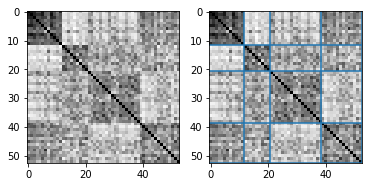

Number of clusters 5


,new label,corr_strength,cluster_size
1,1,0.544276,12
0,2,0.400512,10
4,3,0.371863,9
3,4,0.338628,8
2,5,0.228912,14



 Cluster 1: ['Thai Restaurant', 'Steakhouse', 'Concert Hall', 'Museum', 'Farmers Market', 'Diner', 'Theater', 'Mediterranean Restaurant', 'Plaza', 'Japanese Restaurant', 'Comic Shop', 'Hotel']

 Cluster 2: ['Middle Eastern Restaurant', 'Grocery Store', 'Park', 'Italian Restaurant', 'Indian Restaurant', 'Spa', 'French Restaurant', 'Ice Cream Shop', 'BBQ Joint', 'Liquor Store']

 Cluster 3: ['Brewery', 'Vietnamese Restaurant', 'Bakery', 'Asian Restaurant', 'Yoga Studio', 'Cocktail Bar', 'Café', 'Mexican Restaurant', 'Bar']

 Cluster 4: ['Breakfast Spot', 'Burger Joint', 'Tea Room', 'Coffee Shop', 'Ramen Restaurant', 'Gastropub', 'Sushi Restaurant', 'Pub']

 Cluster 5: ['Pizza Place', 'Movie Theater', 'Restaurant', 'Art Gallery', 'Seafood Restaurant', 'Sporting Goods Shop', 'Arts & Crafts Store', 'Bookstore', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Beer Bar', 'Sandwich Place', 'Dessert Shop', 'Gym']


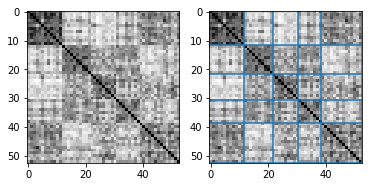

Number of clusters 6


,new label,corr_strength,cluster_size
2,1,0.630353,3
1,2,0.544276,12
3,3,0.492884,7
5,4,0.402799,7
4,5,0.400512,10
0,6,0.228912,14



 Cluster 1: ['Ramen Restaurant', 'Yoga Studio', 'Mexican Restaurant']

 Cluster 2: ['Diner', 'Steakhouse', 'Theater', 'Thai Restaurant', 'Plaza', 'Concert Hall', 'Farmers Market', 'Museum', 'Japanese Restaurant', 'Hotel', 'Mediterranean Restaurant', 'Comic Shop']

 Cluster 3: ['Vietnamese Restaurant', 'Bar', 'Cocktail Bar', 'Brewery', 'Bakery', 'Café', 'Asian Restaurant']

 Cluster 4: ['Breakfast Spot', 'Pub', 'Burger Joint', 'Tea Room', 'Coffee Shop', 'Gastropub', 'Sushi Restaurant']

 Cluster 5: ['Liquor Store', 'Park', 'Italian Restaurant', 'BBQ Joint', 'Indian Restaurant', 'Spa', 'French Restaurant', 'Ice Cream Shop', 'Middle Eastern Restaurant', 'Grocery Store']

 Cluster 6: ['Dessert Shop', 'Sandwich Place', 'Movie Theater', 'Art Gallery', 'Pizza Place', 'Sporting Goods Shop', 'Seafood Restaurant', 'American Restaurant', 'Arts & Crafts Store', 'Vegetarian / Vegan Restaurant', 'Bookstore', 'Gym', 'Restaurant', 'Beer Bar']


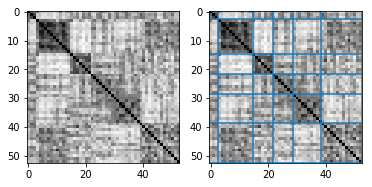

Number of clusters 7


,new label,corr_strength,cluster_size
4,1,0.630353,3
0,2,0.544276,12
2,3,0.492884,7
5,4,0.434741,5
6,5,0.402799,7
3,6,0.400512,10
1,7,0.307979,9



 Cluster 1: ['Ramen Restaurant', 'Mexican Restaurant', 'Yoga Studio']

 Cluster 2: ['Theater', 'Plaza', 'Thai Restaurant', 'Steakhouse', 'Farmers Market', 'Concert Hall', 'Museum', 'Mediterranean Restaurant', 'Japanese Restaurant', 'Hotel', 'Comic Shop', 'Diner']

 Cluster 3: ['Cocktail Bar', 'Asian Restaurant', 'Vietnamese Restaurant', 'Brewery', 'Bakery', 'Café', 'Bar']

 Cluster 4: ['Bookstore', 'Gym', 'Seafood Restaurant', 'Movie Theater', 'Sporting Goods Shop']

 Cluster 5: ['Tea Room', 'Pub', 'Burger Joint', 'Breakfast Spot', 'Coffee Shop', 'Gastropub', 'Sushi Restaurant']

 Cluster 6: ['Indian Restaurant', 'Park', 'Italian Restaurant', 'BBQ Joint', 'Ice Cream Shop', 'French Restaurant', 'Spa', 'Grocery Store', 'Middle Eastern Restaurant', 'Liquor Store']

 Cluster 7: ['Arts & Crafts Store', 'Sandwich Place', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Restaurant', 'Art Gallery', 'Pizza Place', 'Beer Bar', 'Dessert Shop']


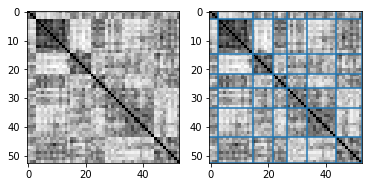

Number of clusters 8


,new label,corr_strength,cluster_size
5,1,0.630353,3
1,2,0.544276,12
3,3,0.492884,7
2,4,0.489593,6
6,5,0.444557,3
4,6,0.434741,5
0,7,0.402799,7
7,8,0.400512,10



 Cluster 1: ['Ramen Restaurant', 'Mexican Restaurant', 'Yoga Studio']

 Cluster 2: ['Plaza', 'Steakhouse', 'Museum', 'Farmers Market', 'Diner', 'Theater', 'Thai Restaurant', 'Mediterranean Restaurant', 'Concert Hall', 'Hotel', 'Comic Shop', 'Japanese Restaurant']

 Cluster 3: ['Café', 'Bar', 'Brewery', 'Vietnamese Restaurant', 'Asian Restaurant', 'Cocktail Bar', 'Bakery']

 Cluster 4: ['Arts & Crafts Store', 'Restaurant', 'Sandwich Place', 'Beer Bar', 'Art Gallery', 'Pizza Place']

 Cluster 5: ['Vegetarian / Vegan Restaurant', 'American Restaurant', 'Dessert Shop']

 Cluster 6: ['Movie Theater', 'Sporting Goods Shop', 'Bookstore', 'Seafood Restaurant', 'Gym']

 Cluster 7: ['Burger Joint', 'Coffee Shop', 'Breakfast Spot', 'Pub', 'Sushi Restaurant', 'Gastropub', 'Tea Room']

 Cluster 8: ['Spa', 'Liquor Store', 'Grocery Store', 'Indian Restaurant', 'Middle Eastern Restaurant', 'BBQ Joint', 'Ice Cream Shop', 'Italian Restaurant', 'Park', 'French Restaurant']


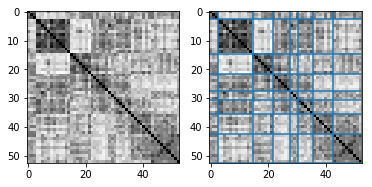

In [17]:
for i in range(4,9):
    print('Number of clusters', i)
    clusterCorrelations(venue_corr, i, True)

# Prediction occurenies of venues by number of other venues in the same cluster

We find a stable cluster of 12 venues wich are correlated the strongest amongst the set of top venues. Let's make predictions for business opportunities for that cluster

In [18]:
stable_cluster= ['Plaza', 'Steakhouse', 'Museum', 'Farmers Market', 'Diner', 'Theater', 'Thai Restaurant', 'Mediterranean Restaurant', 'Concert Hall', 'Hotel', 'Comic Shop', 'Japanese Restaurant']

In [19]:
stable_cluster_corr=venue_corr.loc[stable_cluster, stable_cluster]

We use the corelation amonst the cluster to make a prediction for the number of venues in each neighborhood bases on the other venues

In [20]:
toronto_stable_cluster_venues=toronto_onehot[['Neighborhood']+stable_cluster].groupby('Neighborhood').sum()

In [21]:
stable_cluster_predictions=toronto_stable_cluster_venues.copy()

In [56]:
for i in stable_cluster:
    
    get_cluster=stable_cluster.copy()
    cluster_size=len(get_cluster)
    get_cluster.remove(i)
    prediction=np.dot(np.array(toronto_stable_cluster_venues[get_cluster]), 
                      stable_cluster_corr.loc[get_cluster, i].values.reshape((cluster_size-1,1)))/(cluster_size-1)
    stable_cluster_predictions[[i]]=prediction

In [129]:
stable_cluster_predictions.head()

,Plaza,Steakhouse,Museum,Farmers Market,Diner,Theater,Thai Restaurant,Mediterranean Restaurant,Concert Hall,Hotel,Comic Shop,Japanese Restaurant
Neighborhood,,,,,,,,,,,,
"Adelaide, King, Richmond",1.364651,1.433881,0.948831,1.170009,0.626260,1.453397,1.167228,1.216060,1.367451,1.236531,0.785607,1.001911
Berczy Park,1.388224,1.443571,0.981254,1.157728,0.622091,1.405578,1.171968,1.202566,1.386947,1.280386,0.777446,1.015558
"Brockton, Exhibition Place, Parkdale Village",0.446877,0.467526,0.293527,0.361853,0.194796,0.405841,0.306989,0.359663,0.420309,0.229557,0.226256,0.230862
Business Reply Mail Processing Centre 969 Eastern,0.196595,0.200476,0.107360,0.141951,0.080425,0.245889,0.223040,0.208049,0.199769,0.138205,0.130483,0.161857
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.616739,0.722034,0.459055,0.584584,0.287271,0.740262,0.585896,0.529804,0.717789,0.475847,0.369592,0.473916


In [130]:
toronto_stable_cluster_venues.head()

,Plaza,Steakhouse,Museum,Farmers Market,Diner,Theater,Thai Restaurant,Mediterranean Restaurant,Concert Hall,Hotel,Comic Shop,Japanese Restaurant
Neighborhood,,,,,,,,,,,,
"Adelaide, King, Richmond",2,2,1,2,2,3,2,1,2,5,1,3
Berczy Park,2,2,1,3,1,4,2,1,2,5,0,2
"Brockton, Exhibition Place, Parkdale Village",0,0,0,0,0,1,1,0,0,3,0,2
Business Reply Mail Processing Centre 969 Eastern,0,0,0,1,2,0,0,0,0,1,1,0
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",2,1,0,0,1,1,0,1,0,4,0,2


In [59]:
business_opportunities=stable_cluster_predictions[stable_cluster]-toronto_stable_cluster_venues

In [128]:
business_opportunities.head()

,Plaza,Steakhouse,Museum,Farmers Market,Diner,Theater,Thai Restaurant,Mediterranean Restaurant,Concert Hall,Hotel,Comic Shop,Japanese Restaurant
Neighborhood,,,,,,,,,,,,
"Adelaide, King, Richmond",-0.635349,-0.566119,-0.051169,-0.829991,-1.373740,-1.546603,-0.832772,0.216060,-0.632549,-3.763469,-0.214393,-1.998089
Berczy Park,-0.611776,-0.556429,-0.018746,-1.842272,-0.377909,-2.594422,-0.828032,0.202566,-0.613053,-3.719614,0.777446,-0.984442
"Brockton, Exhibition Place, Parkdale Village",0.446877,0.467526,0.293527,0.361853,0.194796,-0.594159,-0.693011,0.359663,0.420309,-2.770443,0.226256,-1.769138
Business Reply Mail Processing Centre 969 Eastern,0.196595,0.200476,0.107360,-0.858049,-1.919575,0.245889,0.223040,0.208049,0.199769,-0.861795,-0.869517,0.161857
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",-1.383261,-0.277966,0.459055,0.584584,-0.712729,-0.259738,0.585896,-0.470196,0.717789,-3.524153,0.369592,-1.526084


Plaza


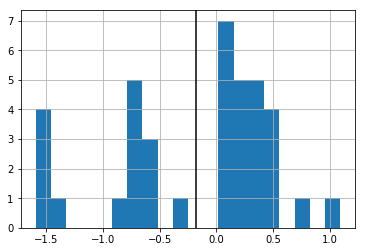

Steakhouse


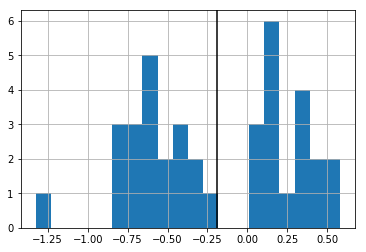

Museum


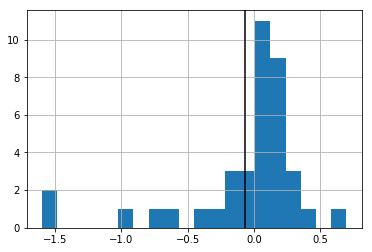

Farmers Market


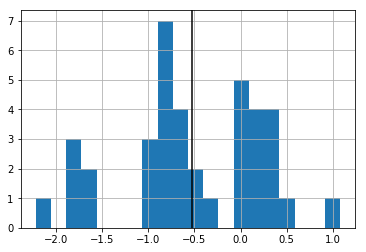

Diner


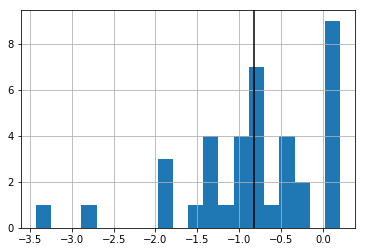

Theater


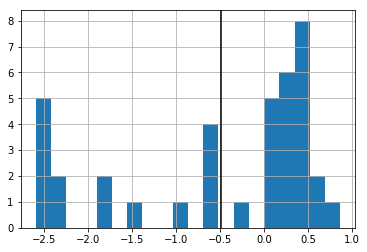

Thai Restaurant


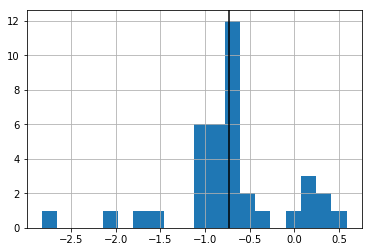

Mediterranean Restaurant


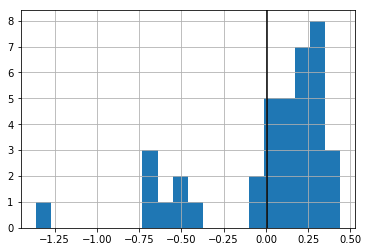

Concert Hall


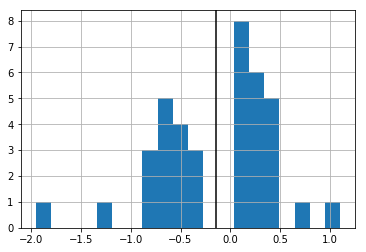

Hotel


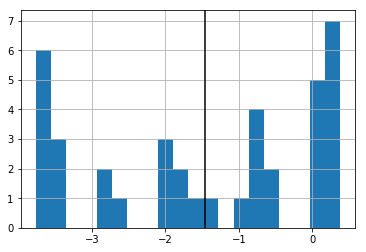

Comic Shop


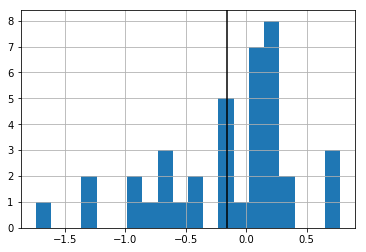

Japanese Restaurant


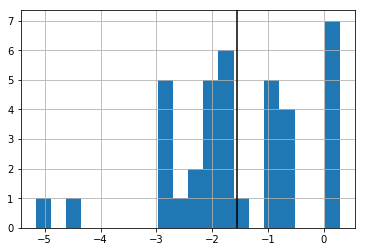

In [104]:
for venue in stable_cluster:
    print(venue)
    (business_opportunities[venue]).hist(bins=20)
    ax=plt.gca()
    ax.axvline((business_opportunities[venue]).mean(), color='k')
    plt.show()

We have positive business opportunities for example for farmer markets and steakhouses.
By looking into the table we can see in which areas.

In [111]:
business_opportunities[['Farmers Market']].sort_values('Farmers Market', ascending=False).head(5)

,Farmers Market
Neighborhood,
Church and Wellesley,1.079083
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.584584
"Chinatown, Grange Park, Kensington Market",0.384936
"Brockton, Exhibition Place, Parkdale Village",0.361853
Davisville,0.289302


In [112]:
business_opportunities[['Steakhouse']].sort_values('Steakhouse', ascending=False).head(5)

,Steakhouse
Neighborhood,
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",0.580544
"The Annex, North Midtown, Yorkville",0.577948
"Brockton, Exhibition Place, Parkdale Village",0.467526
"Harbord, University of Toronto",0.422613
Studio District,0.376031


# Prediction Food Places Occurencies from other occurencies of other venues in the same cluster

Since venues might not be only highly correlated because they support each other and therefore occur often together, but also because similar venues compete with each other and fight for the same business opportunities it might not make sense to use all the other venues from the same cluster for business predictions of some type of venues.

For example if we want to make predictions for restaurants we should splot the cluster into restaurants and places that compete with each other (subcluster1) and make predictions for business opportunites simulatneously, relying only on the other venues (subcluster2) as the correlation with those might indicated supporting character and business opportunities based on those venues.

So we will make bases on the venues of subcluster2 predictions for subcluster1

stable_cluster

In [63]:
subcluster1=['Steakhouse', 'Diner', 'Thai Restaurant', 'Mediterranean Restaurant', 'Japanese Restaurant']

In [65]:
subcluster2=list(set(stable_cluster).difference(set(subcluster1)))

In [66]:
subcluster1

['Steakhouse',
 'Diner',
 'Thai Restaurant',
 'Mediterranean Restaurant',
 'Japanese Restaurant']

In [67]:
subcluster2

['Theater',
 'Hotel',
 'Comic Shop',
 'Farmers Market',
 'Plaza',
 'Museum',
 'Concert Hall']

In [79]:
subcluster1_venues=toronto_onehot[['Neighborhood']+subcluster1].groupby('Neighborhood').sum()

In [81]:
subcluster1_predictions=subcluster1_venues.copy()

In [83]:
for i in subcluster1:
    prediction=np.dot(np.array(toronto_stable_cluster_venues[subcluster2]), 
                      stable_cluster_corr.loc[subcluster2, i].values.reshape((len(subcluster2),1)))/(len(subcluster2))
    subcluster1_predictions[[i]]=prediction

In [126]:
subcluster1_venues.head()

,Steakhouse,Diner,Thai Restaurant,Mediterranean Restaurant,Japanese Restaurant
Neighborhood,,,,,
"Adelaide, King, Richmond",2,2,2,1,3
Berczy Park,2,1,2,1,2
"Brockton, Exhibition Place, Parkdale Village",0,0,1,0,2
Business Reply Mail Processing Centre 969 Eastern,0,2,0,0,0
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",1,1,0,1,2


In [124]:
subcluster1_predictions.head()

,Steakhouse,Diner,Thai Restaurant,Mediterranean Restaurant,Japanese Restaurant
Neighborhood,,,,,
"Adelaide, King, Richmond",1.613646,0.587833,1.306363,1.397698,1.082267
Berczy Park,1.784172,0.628189,1.439477,1.468481,1.150620
"Brockton, Exhibition Place, Parkdale Village",0.448987,0.150567,0.354531,0.383063,0.298843
Business Reply Mail Processing Centre 969 Eastern,0.214643,0.126381,0.227040,0.263486,0.160531
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.801313,0.275691,0.594000,0.607384,0.532451


In [87]:
subcluster1_business_opps=subcluster1_predictions[subcluster1]-subcluster1_venues

In [125]:
subcluster1_business_opps.head()

,Steakhouse,Diner,Thai Restaurant,Mediterranean Restaurant,Japanese Restaurant,overall opportunity
Neighborhood,,,,,,
"Adelaide, King, Richmond",-0.386354,-1.412167,-0.693637,0.397698,-1.917733,-8.024384
Berczy Park,-0.215828,-0.371811,-0.560523,0.468481,-0.849380,-3.058122
"Brockton, Exhibition Place, Parkdale Village",0.448987,0.150567,-0.645469,0.383063,-1.701157,-2.728018
Business Reply Mail Processing Centre 969 Eastern,0.214643,-1.873619,0.227040,0.263486,0.160531,-2.015837
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",-0.198687,-0.724309,0.594000,-0.392616,-1.467549,-4.378320


In [127]:
subcluster1_business_opps['overall opportunity']=subcluster1_business_opps.sum(axis=1)
subcluster1_business_opps.sort_values('overall opportunity', ascending=False).head()

,Steakhouse,Diner,Thai Restaurant,Mediterranean Restaurant,Japanese Restaurant,overall opportunity
Neighborhood,,,,,,
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",0.658777,0.169831,-0.447084,-0.258566,-0.510171,-1.161637
Christie,0.135274,0.014352,0.126034,0.163064,-0.905644,-1.400760
"Parkdale, Roncesvalles",0.000000,0.000000,-1.000000,0.000000,0.000000,-3.000000
Business Reply Mail Processing Centre 969 Eastern,0.214643,-1.873619,0.227040,0.263486,0.160531,-3.023756
"Harbord, University of Toronto",0.410599,0.186082,-0.600396,-0.462351,-0.666002,-3.396200


Steakhouse


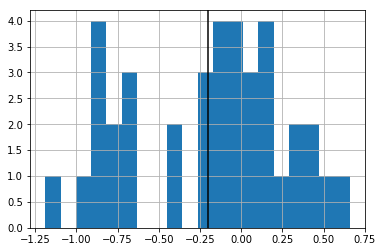

Diner


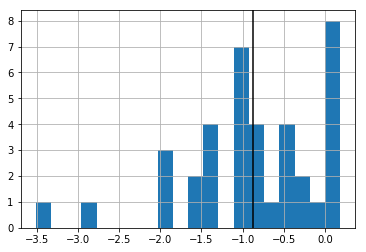

Thai Restaurant


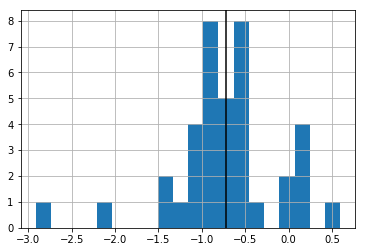

Mediterranean Restaurant


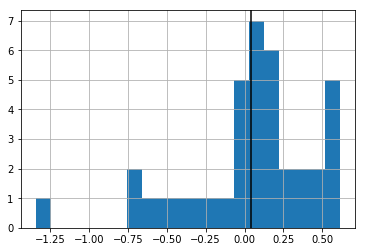

Japanese Restaurant


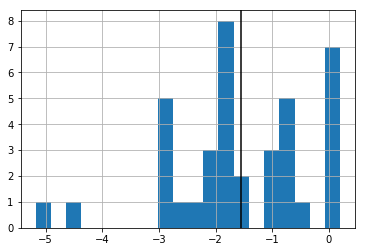

overall opportunity


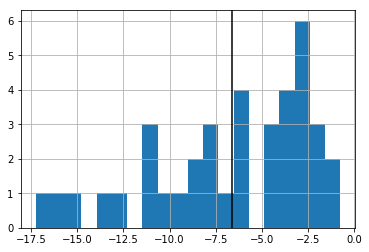

In [114]:
for col in subcluster1_business_opps.columns:
    print(col)
    subcluster1_business_opps[col].hist(bins=20)
    ax=plt.gca()
    ax.axvline(subcluster1_business_opps[col].mean(), color='k')
    plt.show()

We see a business opportunitiy for example for Steakhouses and by looking into the table we see the corr. neighborhood

In [118]:
subcluster1_business_opps[['Steakhouse', 'overall opportunity']].sort_values('Steakhouse', ascending=False).head()

,Steakhouse,overall opportunity
Neighborhood,,
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",0.658777,-0.774425
"The Annex, North Midtown, Yorkville",0.549595,-3.576995
"Brockton, Exhibition Place, Parkdale Village",0.448987,-2.728018
"Harbord, University of Toronto",0.410599,-2.264134
"Moore Park, Summerhill East",0.323825,-3.213267


We see the Neigboorhood Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West and looking at the overall opportunity we see that is is the least saturated by the 
restaurants in sublcluster1

# Discussion

As we have seen we have build some type of systems to regocnize outlieres in the expected number of venues, based on the number of other venues which they correlate with, in order to suggest over- and under-saturated markets and find business opportunities.

We have furhter split a cluster of correlated venues by reason into subclusters of competeting similar venues, and other non-competing venues which might then me supportive. With that we have suggested business opportunities for restaurants based on non-restaurant venues they correlate with.

However we should keep in my a few problems.
Our correlations are based on a very small number of venues and neighborhoods.
We might want to get more neighborhoods and data into account, so that we can also calculate correlation of occurences based on a smaller radius and make the whole correlation calculation more likely to reflect a connection between different venues.

Also one might want to use the clustering only as a feature engineering type of system, in orther to reduce the number of feature inputs (in the last part of this notebook we used subcluster2 as input) and make predictions for competing venues (subcluster1) simultaneously because a too low number in japanese restaurants might be compensated by a too large number in chinese restaurants etc. We could then use the feature inputs and the desires output in more complex models such a random forrests and neural networks, instead of just using a linearized model in which we multiply the number of some venues with a correlation constant and take the mean in order to predict the occurence of another venue. But again for such complex models we have to extend out approach to use much more data.